In [1]:
import json
import  pickle
import numpy as np
import networkx as nx
from shapely.geometry import Polygon, Point, MultiPoint
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau
from scipy.spatial import ConvexHull
import datetime
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (16,26)

In [3]:
Cmat = np.load("../../Cmat.npy")
with open("../../mapping.bin", "rb") as fp:
    mapping = pickle.load(fp)

In [4]:
G = nx.read_graphml("../../Full_network.graphml", node_type=int, edge_key_type=int)

In [5]:
Pop = nx.get_node_attributes(G, 'NP')

In [6]:
with open("../dashboard/data/wards_updated.p", "rb") as fp:
    ward_poly = pickle.load(fp)

In [7]:
with open("../dashboard/data/ward_ts.p", "rb") as fp:
    ward_ts = pickle.load(fp)

In [8]:
ward_area = {}
for w in ward_poly:
    ward_area[w] = Polygon(ward_poly[w]['polygon'][0]).area

In [9]:
ward_area['NAVRANGPURA']

0.000640068376118634

In [10]:
ward_nodes = {}
for w in ward_poly:
    arr = []
    poly = MultiPoint(ward_poly[w]['polygon'][0]).convex_hull
    for j in G:
        point = Point(G.nodes[j]['X'],G.nodes[j]['Y'])
        if poly.contains(point):
            arr.append(j)
    ward_nodes[w] = arr

In [11]:
ward_final = {}
for w in ward_area:
    total_pop = 0
    coeff = 0
    for node in ward_nodes[w]:
        total_pop+=Pop[node]
        for jnode in ward_nodes[w]:
            coeff+=np.exp(-Cmat[mapping[node]][mapping[jnode]])*Pop[node]*Pop[jnode]
    coeff = float(coeff)/(total_pop**2)
    ward_final[w] = (ward_area[w], coeff, total_pop)

In [12]:
def get_vectors(arr):
    dates = []
    cases = []
    for i in arr:
        dates.append(i[0])
        cases.append(i[1])
    return dates, cases

In [13]:
dates = ['-'.join([str(k) for k in j][::-1])  for j in get_vectors(ward_ts['VATVA'])[0]]

In [ ]:
ward_final.keys()

In [ ]:
plt.xticks(rotation=45)
ward1 = 'INDIA COLONY'
ward2 = 'SARDARNAGAR'
arr1 = np.log(np.array(get_vectors(ward_ts[ward1])[1]))*ward_final[ward1][1]**2*ward_final[ward1][0]/(ward_final[ward1][2]*np.log(ward_final[ward1][2]))
arr2 = np.log(np.array(get_vectors(ward_ts[ward2])[1]))*ward_final[ward2][1]**2*ward_final[ward2][0]/(ward_final[ward2][2]*np.log(ward_final[ward2][2]))
print("Correaltion:",max((arr1/arr2)[-1], 1/(arr1/arr2)[-1]))
print("Coeff:",ward_final[ward1][1], ward_final[ward2][1])
print("Factors:",
     ward_final[ward1][1]**2*ward_final[ward1][0]/(ward_final[ward1][2]*np.log(ward_final[ward1][2])),
     ward_final[ward2][1]**2*ward_final[ward2][0]/(ward_final[ward2][2]*np.log(ward_final[ward2][2])))
plt.plot(dates, arr1/arr2)
#plt.plot(dates, arr2)

In [ ]:
curr_case = [ward_ts[w][-1][1] for w in ward_area]

In [ ]:
pop_dense = [float(ward_final[w][2])/ward_final[w][0] for w in ward_area]

In [ ]:
coeff_arr = [ward_final[w][2]/(ward_final[w][1]**2*ward_final[w][0]) for w in ward_area]

In [ ]:
spearmanr(curr_case, coeff_arr)

In [ ]:
spearmanr(curr_case, pop_dense)

In [ ]:
curr_case = [ward_ts[w][-1][1] for w in ward_area]
coeff_arr = [ward_final[w][2]**2*np.log(ward_final[w][2])/(ward_final[w][1]**2*ward_final[w][0]) for w in ward_area]
spearmanr(curr_case, coeff_arr)

In [ ]:
spearmanr(pop_dense, [ward_final[w][1] for w in ward_area])

In [ ]:
# Kendall Tau correlation

In [ ]:
# With population
curr_case = [ward_ts[w][-1][1] for w in ward_area]
coeff_arr = [ward_final[w][2] for w in ward_area]
kendalltau(curr_case, coeff_arr)

In [ ]:
# With population density
curr_case = [ward_ts[w][-1][1] for w in ward_area]
coeff_arr = [float(ward_final[w][2])/ward_final[w][0] for w in ward_area]
kendalltau(curr_case, coeff_arr)

In [ ]:
# With new factor without log
curr_case = [ward_ts[w][-1][1] for w in ward_area]
coeff_arr = [float(ward_final[w][2])/(ward_final[w][1]**2*ward_final[w][0]) for w in ward_area]
kendalltau(curr_case, coeff_arr)

In [ ]:
# With new factor
curr_case = [ward_ts[w][-1][1] for w in ward_area]
coeff_arr = [ward_final[w][2]*np.log(ward_final[w][2])/(ward_final[w][1]**2*ward_final[w][0]) for w in ward_area]
kendalltau(curr_case, coeff_arr)

In [ ]:
# Writing data to csv
fp = open('data/coeff_corr.csv', 'w')
for w in ward_area:
    fp.write(w+','+str(ward_final[w][2]*np.log(ward_final[w][2])/(ward_final[w][1]**2*ward_final[w][0]))+'\n')
fp.close()

In [43]:
# Kendall Tau Plots over all days
density_arr = []
corr_arr = []
ps_arr = []
pd_arr = []
ll = len(dates)
for j in range(1, ll+1):
    curr_case = [ward_ts[w][-j][1] for w in ward_area]
    coeff_arr = [ward_final[w][2]*np.log(ward_final[w][2])/(ward_final[w][1]**2*ward_final[w][0]) for w in ward_area]
    corr_arr.append(kendalltau(curr_case, coeff_arr)[0])
    ps_arr.append(kendalltau(curr_case, coeff_arr)[1])
    coeff_arr = [float(ward_final[w][2])/(ward_final[w][0]) for w in ward_area]
    density_arr.append(kendalltau(curr_case, coeff_arr)[0])
    pd_arr.append(kendalltau(curr_case, coeff_arr)[1])

date_s = pd.Series([datetime.datetime(*j) for j in get_vectors(ward_ts['VATVA'])[0]])

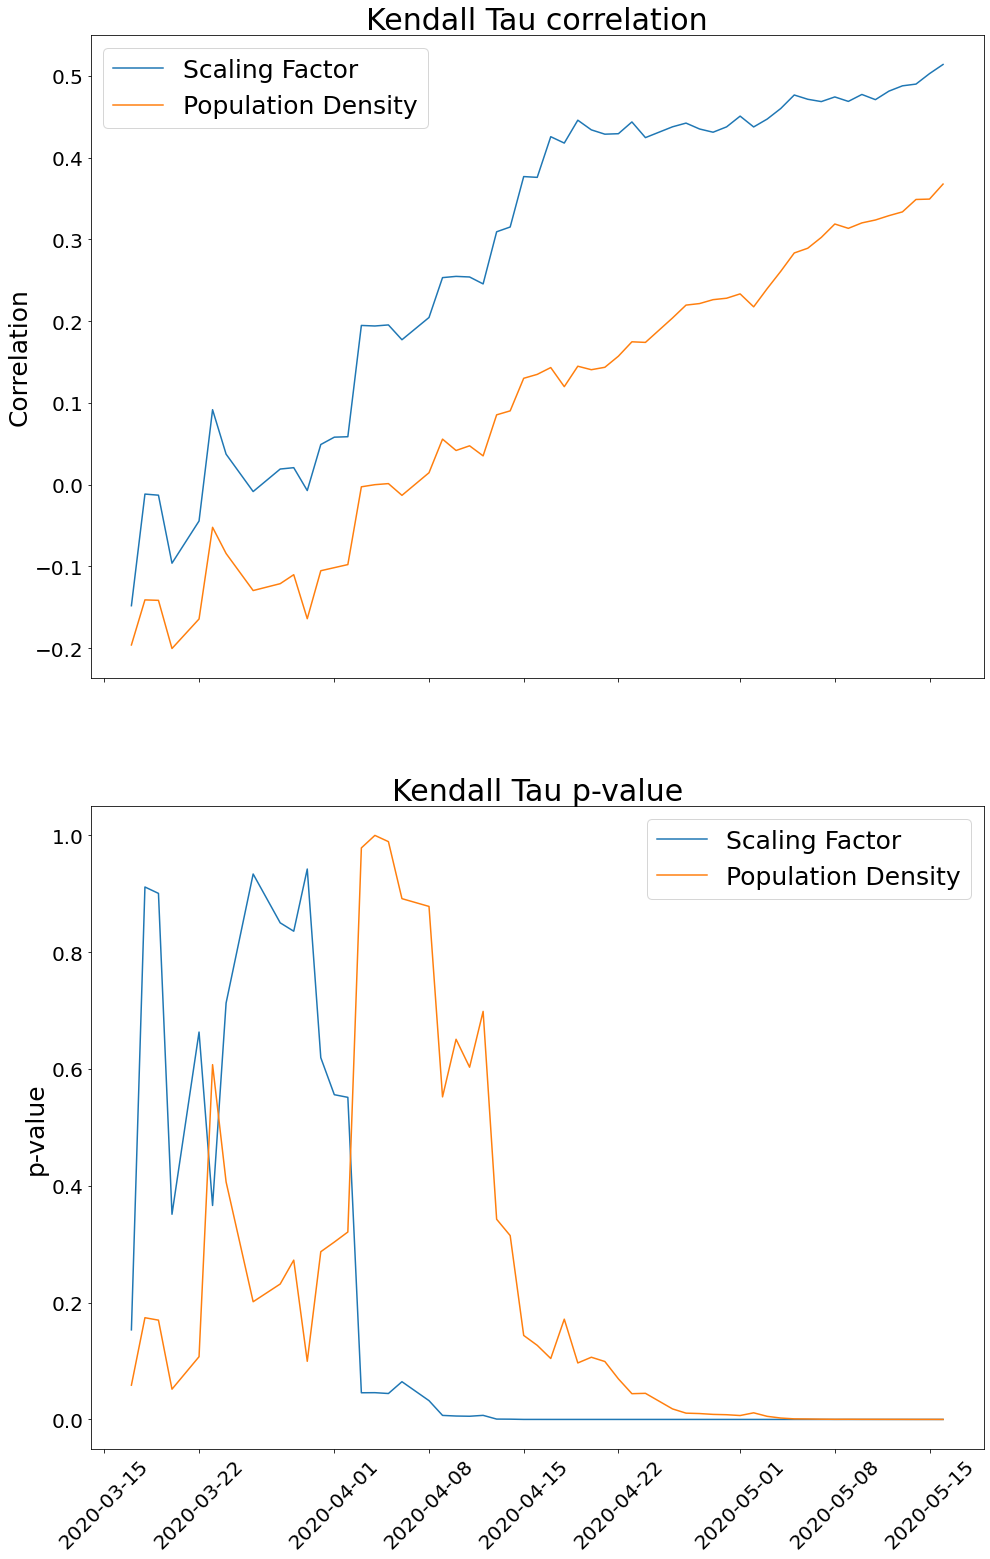

In [54]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

#plt.xlabel('Date', fontsize =20)
#plt.ylabel('Correlation', fontsize =20)
ax1.set_title('Kendall Tau correlation', fontsize=30)
ax1.plot(date_s,corr_arr[::-1], label='Scaling Factor')
ax1.plot(date_s, density_arr[::-1], label='Population Density')
ax1.set_ylabel('Correlation', fontsize=30)
ax1.legend(fontsize =25)
ax1.yaxis.set_tick_params(labelsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

ax2.set_title('Kendall Tau p-value', fontsize=30)
ax2.plot(date_s,ps_arr[::-1], label='Scaling Factor')
ax2.plot(date_s, pd_arr[::-1], label='Population Density')
ax2.legend(fontsize =25)
ax2.set_ylabel('p-value', fontsize=30)
fig.savefig('figures/app.svg')

In [30]:
# Spearman Plots over all days
density_arr = []
corr_arr = []
ll = len(dates)
for j in range(1, ll+1):
    curr_case = [ward_ts[w][-j][1] for w in ward_area]
    coeff_arr = [ward_final[w][2]*np.log(ward_final[w][2])/(ward_final[w][1]**2*ward_final[w][0]) for w in ward_area]
    corr_arr.append(spearmanr(curr_case, coeff_arr)[0])
    coeff_arr = [float(ward_final[w][2])/(ward_final[w][0]) for w in ward_area]
    density_arr.append(spearmanr(curr_case, coeff_arr)[0])

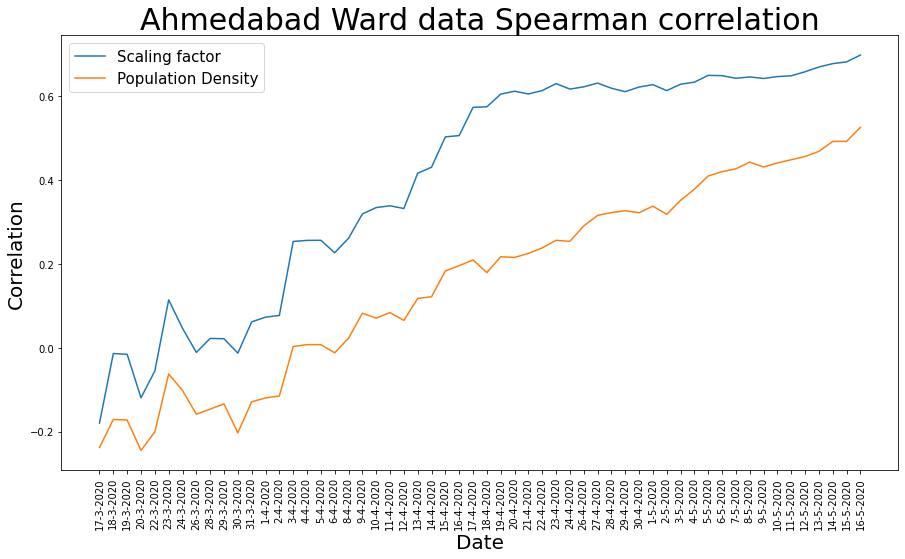

In [31]:
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize =20)
plt.ylabel('Correlation', fontsize =20)
plt.title('Ahmedabad Ward data Spearman correlation', fontsize =30)
plt.plot(dates,corr_arr[::-1], label='Scaling factor')
plt.plot(dates, density_arr[::-1], label='Population Density')
plt.legend(fontsize =15)
plt.savefig('correlation_plots/spearman_correlation.svg')

In [32]:
# Kendall Tau Plots over all days
density_arr = []
corr_arr = []
ll = len(dates)
for j in range(1, ll+1):
    curr_case = [ward_ts[w][-j][1] for w in ward_area]
    coeff_arr = [ward_final[w][2]*np.log(ward_final[w][2])/(ward_final[w][1]**2*ward_final[w][0]) for w in ward_area]
    corr_arr.append(kendalltau(curr_case, coeff_arr)[1])
    coeff_arr = [float(ward_final[w][2])/(ward_final[w][0]) for w in ward_area]
    density_arr.append(kendalltau(curr_case, coeff_arr)[1])

In [33]:
print(min(corr_arr),min(density_arr))

2.1499711064199176e-09 1.8491042716679118e-05


In [ ]:
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize =20)
plt.ylabel('p-value', fontsize =20)
plt.title('Ahmedabad Ward data Kendall Tau p-value', fontsize =30)
plt.plot(dates,corr_arr[::-1], label='Scaling factor')
plt.plot(dates, density_arr[::-1], label='Population Density')
plt.legend(fontsize =15)
plt.savefig('correlation_plots/kendall_tau_pvalue.svg')

In [ ]:
# Spearman Plots over all days
density_arr = []
corr_arr = []
ll = len(dates)
for j in range(1, ll+1):
    curr_case = [ward_ts[w][-j][1] for w in ward_area]
    coeff_arr = [ward_final[w][2]*np.log(ward_final[w][2])/(ward_final[w][1]**2*ward_final[w][0]) for w in ward_area]
    corr_arr.append(spearmanr(curr_case, coeff_arr)[1])
    coeff_arr = [float(ward_final[w][2])/(ward_final[w][0]) for w in ward_area]
    density_arr.append(spearmanr(curr_case, coeff_arr)[1])

In [ ]:
print(min(corr_arr),min(density_arr))

In [ ]:
plt.xticks(rotation=90)
plt.xlabel('Date', fontsize =20)
plt.ylabel('p-value', fontsize =20)
plt.title('Ahmedabad Ward data Spearman p-value', fontsize =30)
plt.plot(dates,corr_arr[::-1], label='Scaling factor')
plt.plot(dates, density_arr[::-1], label='Population Density')
plt.legend(fontsize =15)
plt.savefig('correlation_plots/spearman_pvalue.svg')

In [36]:
arr = []
coeff = []

In [43]:
with open('region_sim4.p', 'rb') as fp:
    S5, S10, S20 = pickle.load(fp)

In [44]:
arr.append(np.array([j[1] for j in S5['timeseries']]))
arr.append(np.array([j[1] for j in S10['timeseries']]))
arr.append(np.array([j[1] for j in S20['timeseries']]))
coeff.append(S5['total_pop']/S5['area'])
coeff.append(S10['total_pop']/S10['area'])
coeff.append(S20['total_pop']/S20['area'])

In [46]:
arr = np.array(arr).T
coeff = np.array(coeff)

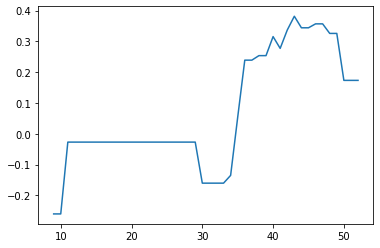

In [48]:
plt.plot([kendalltau(row, coeff)[0] for row in arr])

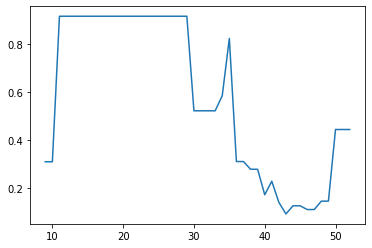

In [49]:
plt.plot([kendalltau(row, coeff)[1] for row in arr])